In [61]:
import os

import pandas as pd 

import matplotlib.pyplot as plt

from cleaning_utils import *

In [31]:
directory = 'data/curated/'

patients_admissions = pd.read_parquet(directory + 'patients_admissions.parquet')

In [32]:
patients_admissions.head(5)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,ethnicity_categorised,los_admission,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dod_consolidated,age_during_admission,age_group,nth_visit,latest_visit
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,WHITE,1 days 03:28:00,F,2131-05-07,NaT,NaT,NaT,0,NaT,64,60-69,1,1
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,WHITE,5 days 11:55:00,M,2082-07-17,NaT,NaT,NaT,0,NaT,71,70-79,1,0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1,WHITE,6 days 18:26:00,M,2082-07-17,NaT,NaT,NaT,0,NaT,75,70-79,2,1
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1,WHITE,2 days 20:34:00,M,2100-05-31,NaT,NaT,NaT,0,NaT,39,30-39,1,1
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,WHITE,3 days 12:49:00,M,2101-11-21,NaT,NaT,NaT,0,NaT,58,50-59,1,1


## Check ICU data 

In [33]:
raw_dir = 'data/raw/'
icu = pd.read_csv(raw_dir + 'ICUSTAYS.csv')
    

In [34]:
## Clean ICU 
icu = standardise_col_names(icu)

In [35]:
icu.head()

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [36]:
## 1. Clean time cols 
time_cols = [col for col in icu.columns if col.endswith('time')]

for col in time_cols:
    icu[col] = pd.to_datetime(icu[col])
    print(f'new dtype: {icu[col].dtype}')

new dtype: datetime64[ns]
new dtype: datetime64[ns]


In [37]:
icu.dbsource.value_counts()

dbsource
carevue       37776
metavision    23620
both            136
Name: count, dtype: int64

DB Source: clinical information system (CIS) was used to record the patient’s ICU data.

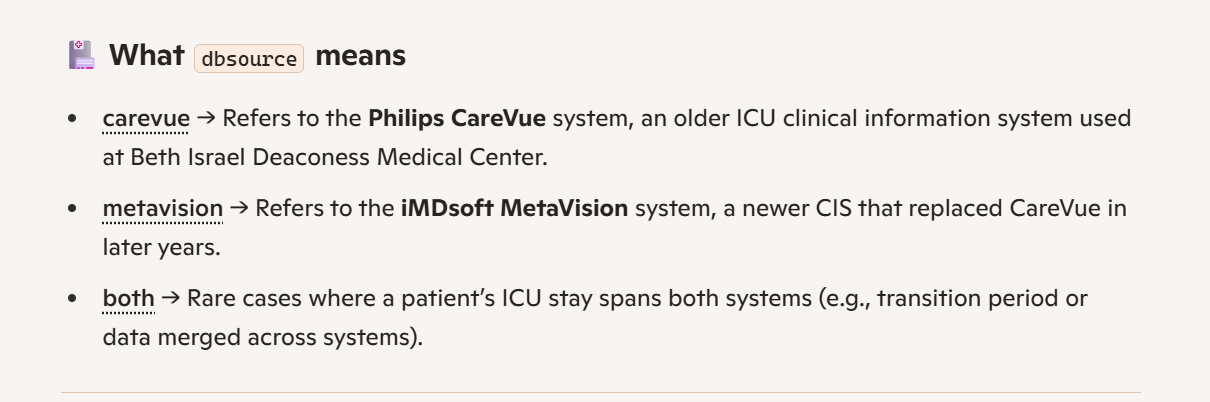

In [38]:
## Compute comparison once 
correct_time_order = icu.outtime > icu.intime

## Sanity checks 
time_check = all(correct_time_order)
print(f'All rows have out time larger than in time? {time_check}')

## How many rows are wrong?
print((correct_time_order.value_counts() * 100/ icu.shape[0]))

## Further checks 
icu[~correct_time_order]

All rows have out time larger than in time? False
True     99.983748
False     0.016252
Name: count, dtype: float64


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
1033,650,499,138066,265303,carevue,MICU,MICU,15,15,2147-01-18 19:11:00,NaT,NaN
6451,6628,5216,130232,262702,carevue,NICU,NICU,26,26,2114-02-26 05:41:00,NaT,NaN
10165,11108,8733,171006,296619,carevue,NICU,NICU,26,26,2190-02-03 07:37:00,NaT,NaN
10507,8216,6462,168585,270511,carevue,NICU,NICU,26,26,2135-04-23 10:06:00,NaT,NaN
13080,12923,10168,184129,292281,carevue,MICU,MICU,52,52,2111-03-06 20:52:00,NaT,NaN
15156,13060,10273,127370,269344,carevue,NICU,NICU,26,26,2153-02-16 21:57:00,NaT,NaN
17759,18665,14712,188201,259704,carevue,NICU,NICU,26,26,2110-01-29 23:41:00,NaT,NaN
18442,12871,10128,148324,246075,carevue,CSRU,CSRU,33,33,2117-03-29 18:58:00,NaT,NaN
27840,25343,19967,146232,234207,carevue,NICU,NICU,26,26,2168-03-02 23:40:00,NaT,NaN
29117,26451,20861,127498,206053,carevue,NICU,NICU,26,26,2136-02-20 17:31:00,NaT,NaN


About .01% of the rows have inaccurate timings --> closer inspection revealed that the outtimes are all NaTs --> how to deal?

In [39]:
## Clean LOS column name
icu_cleaned = icu.rename(columns = {'los':'los_icu_days'})

### Number of ICU stays per patient 

In [40]:
icu.groupby('subject_id')['icustay_id'].count().value_counts().sort_index().head(10)

icustay_id
1     37721
2      5796
3      1619
4       650
5       300
6       151
7        86
8        44
9        29
10       19
Name: count, dtype: int64

In [41]:
## is there an anomaly? 
icu.groupby('subject_id')['icustay_id'].count().describe()

count    46476.000000
mean         1.323952
std          0.996007
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: icustay_id, dtype: float64

In [42]:
## Who are the patients with very high icu counts?
top_10_icu_patients = icu.groupby('subject_id')['icustay_id'].count().sort_values(ascending = False).head(10).index
top_10_icu_patients

Index([13033, 109, 11861, 5060, 20643, 19213, 7809, 11318, 5727, 23657], dtype='int64', name='subject_id')

In [43]:
icu[icu.subject_id.isin(top_10_icu_patients)].head()

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
159,119,109,183350,277062,carevue,MICU,MICU,12,12,2137-11-04 19:37:58,2137-11-05 17:04:39,0.8935
160,120,109,183350,298630,carevue,MICU,MICU,15,15,2137-11-09 13:31:16,2137-11-12 17:56:27,3.1842
161,121,109,183350,208379,carevue,MICU,MICU,12,12,2137-11-14 20:47:58,2137-11-20 22:38:41,6.0769
162,122,109,128755,271885,carevue,MICU,MICU,15,15,2138-04-16 17:45:30,2138-04-19 18:00:22,3.0103
163,123,109,164029,290868,carevue,SICU,SICU,57,57,2140-01-19 13:25:51,2140-01-21 13:20:11,1.9961


In [44]:
## For the number of icu in the same admission
icu.groupby('hadm_id')['icustay_id'].count().sort_values(ascending = False).head(10)

hadm_id
163281    7
186706    7
123178    6
109520    6
175448    6
131118    5
153926    5
108976    5
154357    5
129611    5
Name: icustay_id, dtype: int64

## Feature engineering: nth ICU per patient admission 

In [45]:
icu['nth_visit_per_patient_admission'] = icu.groupby(['subject_id', 'hadm_id'])['intime'].rank(method = 'dense').astype(int)

## Check 
example_hadm_id = 163281
icu[icu.hadm_id == example_hadm_id].head()[['subject_id', 'hadm_id', 'icustay_id', 'intime', 'outtime', 'nth_visit_per_patient_admission']]

,subject_id,hadm_id,icustay_id,intime,outtime,nth_visit_per_patient_admission
19466,18108,163281,240938,2122-03-03 03:12:52,2122-03-11 22:48:06,1
19467,18108,163281,200137,2122-03-19 09:14:17,2122-03-22 17:32:16,2
19468,18108,163281,295394,2122-03-25 04:11:50,2122-03-26 16:05:21,3
19469,18108,163281,240543,2122-04-03 02:08:57,2122-04-05 18:31:01,4
19470,18108,163281,277556,2122-04-07 23:29:04,2122-04-13 01:29:29,5


# Transformation

In [46]:
print(icu.shape)
print(patients_admissions.shape)

(61532, 13)
(58878, 31)


### Basic sanity checks 

In [47]:
all_admission_ids = set(patients_admissions.hadm_id.unique())
all_icu_admission_ids = set(icu.hadm_id.unique())
print(f'total number of admissions : {len(all_admission_ids)}')
print(f'total number of ICU admissions : {len(all_icu_admission_ids)}')

## How many admissions didnt result in ICUs?
print(len(all_admission_ids.difference(all_icu_admission_ids)))

## Which ICU admission is not in admissions table (sanity check)
print(len(all_icu_admission_ids.difference(all_admission_ids)))

total number of admissions : 58878
total number of ICU admissions : 57786
1176
84


### ICU left join patient admission --> ICU is the base table

In [48]:
patients_admissions_icu = icu.merge(patients_admissions, on = ['subject_id', 'hadm_id'], how = 'left')

In [49]:
## Second check 
print(patients_admissions_icu.shape)

(61532, 42)


In [50]:
## Understand currrent dataset
pd.set_option('display.max_columns', None)

example_sub_id = 23657
patients_admissions_icu[(patients_admissions_icu.subject_id == example_sub_id) & 
                        (patients_admissions_icu.hadm_id == 125544)]

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,nth_visit_per_patient_admission,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,ethnicity_categorised,los_admission,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dod_consolidated,age_during_admission,age_group,nth_visit,latest_visit
30835,29950,23657,125544,295835,metavision,MICU,MICU,23,23,2145-02-19 12:45:42,2145-02-22 17:35:10,3.2010,1,2145-02-18 20:45:00,2145-02-27 18:30:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,LEFT AGAINST MEDICAL ADVI,Private,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2145-02-18 12:20:00,2145-02-18 22:17:00,DEHYDRATION,0.0,1.0,BLACK,8 days 21:45:00,M,2112-11-14,NaT,NaT,NaT,0.0,NaT,32.0,30-39,6.0,0.0
30836,29951,23657,125544,254166,metavision,MICU,MICU,23,23,2145-02-24 13:18:43,2145-02-26 22:08:56,2.3682,2,2145-02-18 20:45:00,2145-02-27 18:30:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,LEFT AGAINST MEDICAL ADVI,Private,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,2145-02-18 12:20:00,2145-02-18 22:17:00,DEHYDRATION,0.0,1.0,BLACK,8 days 21:45:00,M,2112-11-14,NaT,NaT,NaT,0.0,NaT,32.0,30-39,6.0,0.0


### Understanding the data

In this example, this patient (id = 23657) was admitted (id = 125544) from 18th Feb until 27th Feb for a total of 8 days and 21 hours. 

During this period, he/she was sent to the ICU twice: the first was from 19th Feb to 22th Feb for 3.2 days, and then from 24th Feb to 26th Feb. 

Timeline 
* 18th Feb: admitted
* 19th Feb: first ICU
* 22th Feb: out of first ICU
* 24th Feb: second ICU
* 26th Feb: out of second ICU
* 27th Feb: discharged 

The diagnosis for the admission was dehydration

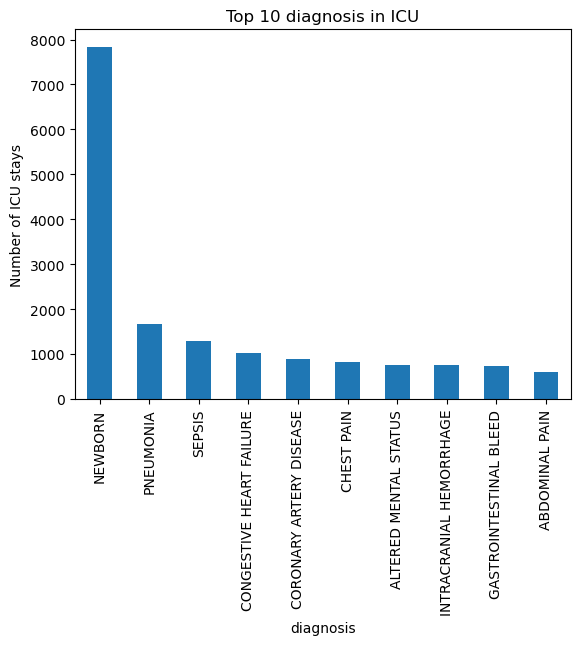

In [64]:
## Which disease causes the most icu visits?
patients_admissions_icu.groupby('diagnosis')['icustay_id'].count().sort_values(ascending = False).head(10).plot(kind = 'bar')
plt.title('Top 10 diagnosis in ICU')
plt.ylabel('Number of ICU stays')
plt.show()

### Feature engineering

In [52]:
## Creating time-to-icu (if first ICU, then time from admission to ICU - otherwise, time from the latest ICU

## Init col 
patients_admissions_icu['time_to_icu'] = np.nan

## For first ICUs, find admission time to ICU
first_icu_mask = patients_admissions_icu.nth_visit_per_patient_admission == 1
patients_admissions_icu.loc[first_icu_mask, 'time_to_icu'] = patients_admissions_icu.loc[first_icu_mask, 'intime']\
                                                             - patients_admissions_icu.loc[first_icu_mask, 'admittime']

## For the rest, find time from the previous ICU 

## We first need get the lagged icu outtime 
## First sort 
patients_admissions_icu.sort_values(['subject_id', 'hadm_id', 'intime', 'outtime'])
## Now add the lagged icu outtime
patients_admissions_icu['lagged_icu_outtime'] = patients_admissions_icu.groupby(['subject_id', 'hadm_id'])['outtime'].shift(1)

## Sanity check 
example_hadm_id = 131118
patients_admissions_icu[patients_admissions_icu.hadm_id == example_hadm_id][['subject_id', 'hadm_id', 'intime'
                                                                             ,'outtime', 'lagged_icu_outtime','nth_visit_per_patient_admission']]
## Now, add time_to_icu for the rest of the rows 
patients_admissions_icu.loc[~first_icu_mask, 'time_to_icu'] = patients_admissions_icu.loc[first_icu_mask, 'intime']\
                                                             - patients_admissions_icu.loc[first_icu_mask, 'lagged_icu_outtime']


C:\Users\tanip\AppData\Local\Temp\ipykernel_13768\1142460383.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<TimedeltaArray>
['3 days 09:47:38', '0 days 00:01:29', '0 days 20:39:20', '0 days 04:16:42',
 '0 days 00:02:04', '0 days 00:01:05', '0 days 00:12:44', '1 days 08:19:53',
 '0 days 16:09:23', '0 days 00:02:46',
 ...
 '0 days 00:35:10', '0 days 07:12:02', '0 days 00:01:23', '0 days 00:00:52',
 '0 days 00:01:29', '3 days 16:10:16', '0 days 06:56:16', '0 days 08:54:11',
 '0 days 02:38:10', '0 days 00:00:54']
Length: 57786, dtype: timedelta64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  patients_admissions_icu.loc[first_icu_mask, 'time_to_icu'] = patients_admissions_icu.loc[first_icu_mask, 'intime']\


In [53]:
## Check
pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.lagged_icu_outtime)
pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.intime)
# pd.api.types.is_datetime64_any_dtype(patients_admissions_icu.time_to_icu)
patients_admissions_icu.time_to_icu.dtype

dtype('O')

In [54]:
patients_admissions_icu[['intime', 'admittime']].dtypes

intime       datetime64[ns]
admittime    datetime64[ns]
dtype: object

### Feature engineering: icu mortality 

If death occurs within 6 hours before entering ICU, or 6 hours after exiting ICU

In [56]:
patients_admissions_icu['icu_mortality'] = (
    (patients_admissions_icu["dod_consolidated"] >= patients_admissions_icu["intime"] - pd.Timedelta(hours=6)) &
    (patients_admissions_icu["dod_consolidated"] <= patients_admissions_icu["outtime"] + pd.Timedelta(hours=6))
).astype(int)

## Check 
patients_admissions_icu.icu_mortality.value_counts()

icu_mortality
0    56918
1     4614
Name: count, dtype: int64

## Some analysis

In [57]:
pd.DataFrame(patients_admissions_icu.groupby('first_careunit')['icu_mortality'].mean().sort_values(ascending=False))

,icu_mortality
first_careunit,
MICU,0.105273
SICU,0.091328
CCU,0.088662
TSICU,0.084801
CSRU,0.032216
NICU,0.006543


In [58]:
## Save as transformed

# Save data

In [59]:
patients_admissions_icu.to_parquet("data/curated/icu_patients_admissions.parquet")